# **Source code**
Poniżej znajduje się sekcja zawierająca sprawozdanie






---



## **Imports**

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm as tqdm
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv1D, MaxPooling1D, Layer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam, SGD
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras import regularizers
from numpy import savetxt
import matplotlib.pyplot as plt
import os
import csv
tf.random.set_seed(None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory = "/content/drive/MyDrive/EIO-projekt/test_results/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).







---


## **Constants**

Model's constants

In [ ]:
epochs = 10                ##  Liczba epok 
batch_size = 64           ##  Wielkość batch
dropout_rate = 0          ##  0 => drop layer off  
momentum = 1              ##  1 => batch_normalization off
test_iteration_count = 5  ##  Liczba iteracji uczącej sięc
weight_decay = 0.001      ##  Współczynnik wygasania wag przy wykorzystaniu AdamW
optimizer = Adam          ##  Defaultowy optymalizator

Test's constants

In [ ]:
num_classes = 10
data_size = 100
dataset_size = 10000

optimizers = [AdamW, Adam, SGD]
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])
lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)




---


## **Utils functions**

In [ ]:
def generate_random_data_1D(data_size, dataset_size):
  return np.array([tf.random.uniform(shape=[data_size]) for _ in tqdm(range(dataset_size), desc = "Generating random data progress")])

In [ ]:
def generate_output_data(model, x):
  return model.predict(x)

In [ ]:
def calculate_weights_difference(weight_1, weight_2):
  if len(weight_1) != len(weight_2):
    return None
  euclidean_dist = np.array([])
  for i in range(len(weight_1)):
    euclidean_dist = np.append(euclidean_dist,tf.norm(weight_1[i]-weight_2[i], ord='euclidean').numpy())
  return euclidean_dist

In [ ]:
def calculate_accumulated_weights_difference(weight_1, weight_2):
  tensors = calculate_weights_difference(weight_1, weight_2)
  sum = 0
  for tensor in tensors:
    sum += tensor
  return sum

In [ ]:
def save_to_file(filename, cawd, cawd_mean, cwd, cwd_mean, accuracy, loss, best_accuracy, best_accuracy_mean, accuracy_mean, loss_mean):
  if not os.path.isdir(directory):
    os.makedirs(directory)
  f = open(directory+filename+".txt", 'w')
  f.write("'calculated accumulated weights difference': "+np.array2string(cawd, separator = ",")+"\n")
  f.write("'mean of calculated accumulated weights difference': "+np.array2string(cawd_mean, separator = ",")+"\n")
  f.write("'calculatd weights difference': "+np.array2string(cwd, separator = ",")+"\n")
  f.write("'mean of calculated weights difference': "+np.array2string(cwd_mean, separator = ",")+"\n")
  f.write("'best accuracy': "+np.array2string(best_accuracy, separator = ",")+"\n")
  f.write("'mean  of best accuracy': "+np.array2string(best_accuracy_mean, separator = ",")+"\n")
  f.write("'accuracy': "+np.array2string(accuracy, separator = ",")+"\n")
  f.write("'mean of accuracy': "+np.array2string(accuracy_mean, separator = ",")+"\n")
  f.write("'loss': "+np.array2string(loss, separator = ",")+"\n")
  f.write("'loss_mean': "+np.array2string(loss_mean, separator = ",")+"\n")
  f.close()
  print("File - "+filename+" - saved")

In [ ]:
def generate_x_deep():
  x = generate_random_data_1D(data_size, dataset_size)
  return x

In [ ]:
def generate_x_conv():
  x = generate_random_data_1D(data_size, dataset_size)
  x = np.reshape(x, (dataset_size, data_size, 1))
  return x

In [ ]:
def test(model, x, y, model_creating_function, model_learn_count, filename, model_params={},  layer_params = {}, batch_size = batch_size, epochs=epochs):
  cawd = np.array([])
  cwd = []
  accuracy = []
  best_accuracy = []
  loss = []

  for _ in tqdm(range(model_learn_count), desc = "Test progress"):
    print("*"*10+">ITERACJA<"+"*"*10)
    learning_model = model_creating_function(**model_params, layer_params=layer_params)
    hist = learning_model.fit(x, y, batch_size=batch_size, epochs=epochs).history
    accuracy.append(hist['accuracy'])
    best_accuracy.append(max(hist['accuracy']))
    loss.append(hist['loss'])
    cawd = np.append(cawd,calculate_accumulated_weights_difference(model.get_weights(), learning_model.get_weights()))
    cwd.append(calculate_weights_difference(model.get_weights(), learning_model.get_weights()))
    
  cwd = np.array(cwd)
  accuracy = np.array(accuracy)
  accuracy_mean = np.mean(accuracy, axis = 0)
  best_accuracy = np.array(best_accuracy)
  best_accuracy_mean = np.mean(best_accuracy)
  loss = np.array(loss)
  loss_mean = np.mean(loss, axis = 0)
  cawd_mean = np.mean(cawd)
  cwd_mean = np.mean(cwd, axis=0)
  save_to_file(filename, cawd, cawd_mean, cwd, cwd_mean, accuracy, loss, best_accuracy, best_accuracy_mean, accuracy_mean, loss_mean)
  return {'accuracy_mean':accuracy_mean,
          'best_accuracy_mean':best_accuracy_mean,
          'calculated accumulated weights difference':cawd,
          'mean of calculated accumulated weights difference':cawd_mean,
          'calculatd weights difference':cwd,
          'mean of calculated weights difference':cwd_mean,
          'accuracy':accuracy,
          'loss':loss,
          'loss_mean':loss_mean,
          'best accuracy':best_accuracy}

NameError: ignored

In [ ]:
def present_test_results(result_dict):
  plt.figure(1)
  plt.plot(result_dict['loss_mean'])
  plt.title("Wykres wartości uśrednianej funkcji loss w danych epokach")
  plt.xlabel("Epoki")
  plt.ylabel("Wartość funkcji loss")
  plt.show()
  print("*--*"*30)
  plt.figure(2)
  plt.plot(result_dict['accuracy_mean'])
  plt.title("Wykres wartości uśrednianej funkcji celności w danych epokach")
  plt.xlabel("Epoki")
  plt.ylabel("Wartość funkcji celności")
  plt.show()
  print("*--*"*30)
  print("Największa otrzymana wartość accuracy przez poszczególne iteracje:")
  [print("\tIteration numer "+str(idx)+"\taccuracy: "+str(ba)) for idx, ba in enumerate(result_dict["best accuracy"])]
  print("*--*"*30)
  print("Średnia różnica wartości wag w poszczególnyh wektorach wag:")
  [print("\tWektorach wag nr: "+str(idx)+"\tRóżnica: "+str(wd)) for idx, wd in enumerate(result_dict["mean of calculated weights difference"])]
  print("*--*"*30)
  print("Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: "+str(result_dict["mean of calculated accumulated weights difference"]))
  print("^^^"*30)

In [ ]:
def present_test_results_short(result_dict):
  plt.figure(1)
  plt.plot(result_dict['loss_mean'])
  plt.title("Wykres wartości uśrednianej funkcji loss w danych epokach")
  plt.xlabel("Epoki")
  plt.ylabel("Wartość funkcji loss")
  plt.show()
  print("*--*"*30)
  plt.figure(2)
  plt.plot(result_dict['accuracy_mean'])
  plt.title("Wykres wartości uśrednianej funkcji celności w danych epokach")
  plt.xlabel("Epoki")
  plt.ylabel("Wartość funkcji celności")
  plt.show()
  print("*--*"*30)
  print("Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: "+str(result_dict["mean of calculated accumulated weights difference"]))
  print("^^^"*30)




---

---


## **Models creating functions**

### **Deep learning Model**

In [ ]:
def create_template_model(data_size=data_size, num_classes=num_classes , optimizer = optimizer(),
                          dense_1_units = 32, dense_2_units = 64, dropout_rate = dropout_rate,
                          momentum = momentum, layer_params = {}):
  model = Sequential()
  model.add(Dense(dense_1_units, input_dim=data_size, activation="relu", **layer_params))
  model.add(BatchNormalization(momentum=momentum))
  model.add(Dense(dense_2_units, input_dim=data_size, activation="relu", **layer_params))
  model.add(Dropout(dropout_rate))
  model.add(Dense(num_classes, activation="softmax"))
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  model.build(input_shape=(data_size,))
  return model

### **Convolutional Model**

In [ ]:
def create_template_conv_model(data_size=data_size, num_classes=num_classes , optimizer = optimizer(),
                               conv_1_units = 16, conv_2_units = 32, dropout_rate = dropout_rate,
                               momentum = momentum, layer_params = {}):
  model = Sequential()
  model.add(Input(shape = [data_size, 1]))
  model.add(Conv1D(filters=conv_1_units, kernel_size=3, strides = 1,
                   activation='relu', padding='valid', data_format='channels_last', **layer_params))
  model.add(Conv1D(filters=conv_2_units, kernel_size=3, activation='relu', padding='valid', **layer_params))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(32,activation="relu", **layer_params))
  model.add(Dropout(dropout_rate))
  model.add(BatchNormalization(momentum=momentum))
  model.add(Dense(num_classes, activation="softmax"))
  model.compile(optimizer = optimizer,
                loss = 'mse',
                metrics = ['accuracy'])
  model.build(input_shape=(data_size, 1))
  return model




---


---

---




## **Model tests**

Data initalization

In [ ]:
x = generate_x_deep()
x_conv = generate_x_conv()

base_deep_model = create_template_model()
base_conv_model = create_template_conv_model()

y = generate_output_data(base_deep_model, x)
y_conv = generate_output_data(base_conv_model, x_conv)



---

---




## **Deep learning model's tests**




---




## **Optimizier effectivness test**



### **Optimizer Adam**

In [ ]:
model_params = {"optimizer":optimizers[1]()}
toa = test(base_deep_model, x, y, create_template_model, test_iteration_count, "toa", model_params = model_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3499 - accuracy: 0.3266
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2699 - accuracy: 0.6156
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2647 - accuracy: 0.7026
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.7469
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2605 - accuracy: 0.7685
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2595 - accuracy: 0.7836
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2589 - accuracy: 0.7963
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2585 - accuracy: 0.8012
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2584 - accuracy: 0.8025
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 




### **Optimizer AdamW**

In [ ]:
model_params = {"optimizer":optimizers[0](weight_decay = 0.01)}
#toaw = test(base_deep_model, x, y, create_template_model, test_iteration_count, "toaw", model_params = model_params)



### **Optimizer SGD**

In [ ]:
model_params = {"optimizer":optimizers[2]()}
tosgd = test(base_deep_model, x, y, create_template_model, test_iteration_count, "tosgd", model_params=model_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.4354 - accuracy: 0.1818
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.3478 - accuracy: 0.2979
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.3198 - accuracy: 0.3551
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.3068 - accuracy: 0.3976
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2991 - accuracy: 0.4384
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2943 - accuracy: 0.4703
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2896 - accuracy: 0.4825
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2872 - accuracy: 0.5031
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2844 - accuracy: 0.5317
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 



---




## **Effect of the momentum parameter using batch_normalization**

In [ ]:
toa_m = []
momentum_values = [0.99, 0.95, 0.75, 0.50, 0.25, 0]
for i in momentum_values:
  model_params = {"momentum" : i}
  toa_m.append(test(base_deep_model, x, y, create_template_model, test_iteration_count, "toa_m"+str(i), model_params=model_params))

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3375 - accuracy: 0.3590
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2690 - accuracy: 0.6340
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2639 - accuracy: 0.6816
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2611 - accuracy: 0.7195
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2600 - accuracy: 0.7603
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2594 - accuracy: 0.7786
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2587 - accuracy: 0.7931
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2585 - accuracy: 0.8051
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2579 - accuracy: 0.8035
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2989 - accuracy: 0.5398
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2617 - accuracy: 0.7408
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2592 - accuracy: 0.7755
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2584 - accuracy: 0.8066
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2581 - accuracy: 0.8258
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.8298
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2575 - accuracy: 0.8389
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2576 - accuracy: 0.8336
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2573 - accuracy: 0.8403
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2934 - accuracy: 0.5457
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2609 - accuracy: 0.7664
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2592 - accuracy: 0.7953
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2588 - accuracy: 0.8054
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.8168
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2578 - accuracy: 0.8257
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2578 - accuracy: 0.8272
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2576 - accuracy: 0.8422
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2575 - accuracy: 0.8416
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2904 - accuracy: 0.5711
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2605 - accuracy: 0.7650
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2589 - accuracy: 0.7939
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8098
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2577 - accuracy: 0.8307
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2581 - accuracy: 0.8278
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2575 - accuracy: 0.8418
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2575 - accuracy: 0.8399
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2575 - accuracy: 0.8400
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2880 - accuracy: 0.5968
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2611 - accuracy: 0.7581
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2592 - accuracy: 0.7761
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2587 - accuracy: 0.7978
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8041
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2587 - accuracy: 0.8119
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2583 - accuracy: 0.8203
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2578 - accuracy: 0.8300
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2580 - accuracy: 0.8342
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2983 - accuracy: 0.5594
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2612 - accuracy: 0.7390
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2593 - accuracy: 0.7828
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2583 - accuracy: 0.7842
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.7970
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2585 - accuracy: 0.8082
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2577 - accuracy: 0.8163
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.8254
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2576 - accuracy: 0.8318
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 



---

---
## **Effect of the batch_size parameter using batch_normalization**

In [ ]:
toa_bs = []
batch_size_values = [8, 16, 32, 64, 128, 256]
for i in batch_size_values:
  fit_params = {"batch_size" : i}
  toa_bs.append(test(base_deep_model, x, y, create_template_model, test_iteration_count, "toa_bs"+str(i), 
  **fit_params))

**********>ITERACJA<**********
Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2738 - accuracy: 0.6637
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2596 - accuracy: 0.7723
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2584 - accuracy: 0.8137
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2588 - accuracy: 0.8158
Epoch 5/10
1250/1250 [==============================] - 3s 3ms/step - loss: 2.2582 - accuracy: 0.8167
Epoch 6/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2585 - accuracy: 0.8212
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2587 - accuracy: 0.8223
Epoch 8/10
1250/1250 [==============================] - 3s 3ms/step - loss: 2.2583 - accuracy: 0.8164
Epoch 9/10
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2579 - accuracy: 0.8241
Epoch 10/10
1250/1250 [============================

**********>ITERACJA<**********
Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 2.2735 - accuracy: 0.6688
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2593 - accuracy: 0.7914
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2580 - accuracy: 0.8201
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2585 - accuracy: 0.8208
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2580 - accuracy: 0.8180
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2581 - accuracy: 0.8243
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 2.2581 - accuracy: 0.8315
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2577 - accuracy: 0.8324
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 2.2580 - accuracy: 0.8300
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - 

**********>ITERACJA<**********
Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2862 - accuracy: 0.5806
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2600 - accuracy: 0.7610
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2583 - accuracy: 0.7930
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2573 - accuracy: 0.8114
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2577 - accuracy: 0.8264
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2575 - accuracy: 0.8317
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2578 - accuracy: 0.8364
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2574 - accuracy: 0.8455
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 2.2572 - accuracy: 0.8519
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3083 - accuracy: 0.5279
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2611 - accuracy: 0.7446
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2594 - accuracy: 0.7884
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2586 - accuracy: 0.8019
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8194
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2583 - accuracy: 0.8300
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2576 - accuracy: 0.8364
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2573 - accuracy: 0.8337
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2574 - accuracy: 0.8428
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
79/79 [==============================] - 1s 3ms/step - loss: 2.3185 - accuracy: 0.4953
Epoch 2/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.7429
Epoch 3/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2599 - accuracy: 0.7895
Epoch 4/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2593 - accuracy: 0.8000
Epoch 5/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8099
Epoch 6/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2583 - accuracy: 0.8098
Epoch 7/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.8165
Epoch 8/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2580 - accuracy: 0.8230
Epoch 9/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2575 - accuracy: 0.8216
Epoch 10/10
79/79 [==============================] - 0s 3ms/step - loss: 2.2576 - accur

**********>ITERACJA<**********
Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 2.3269 - accuracy: 0.4498
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2657 - accuracy: 0.7091
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2624 - accuracy: 0.7424
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2611 - accuracy: 0.7708
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2600 - accuracy: 0.7693
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2598 - accuracy: 0.7780
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2591 - accuracy: 0.7953
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2591 - accuracy: 0.8017
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2587 - accuracy: 0.8083
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 2.2585 - accur



---
## **Effect of the drop_out rate parameter**

In [ ]:
toa_dor = []
dropout_rate_values = [0, 0.2, 0.4, 0.6, 0.8]
for i in dropout_rate_values:
  model_params = {"dropout_rate" : i}
  toa_dor.append(test(base_deep_model, x, y, create_template_model, test_iteration_count, "toa_dor"+str(i), model_params=model_params))

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3044 - accuracy: 0.5375
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2609 - accuracy: 0.7325
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2592 - accuracy: 0.7850
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8055
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.8130
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2581 - accuracy: 0.8257
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2577 - accuracy: 0.8374
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.8365
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2574 - accuracy: 0.8455
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3085 - accuracy: 0.4934
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2628 - accuracy: 0.7278
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2610 - accuracy: 0.7558
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2594 - accuracy: 0.7808
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2592 - accuracy: 0.7881
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2589 - accuracy: 0.8026
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2589 - accuracy: 0.8150
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2584 - accuracy: 0.8239
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.8240
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3280 - accuracy: 0.4671
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2645 - accuracy: 0.7245
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2627 - accuracy: 0.7402
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2613 - accuracy: 0.7563
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2605 - accuracy: 0.7642
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2605 - accuracy: 0.7839
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2600 - accuracy: 0.7755
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2594 - accuracy: 0.7786
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2595 - accuracy: 0.7833
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3443 - accuracy: 0.4560
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2658 - accuracy: 0.7313
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2647 - accuracy: 0.7420
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2641 - accuracy: 0.7504
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2627 - accuracy: 0.7398
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2628 - accuracy: 0.7372
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2622 - accuracy: 0.7463
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.7525
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.7582
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.4127 - accuracy: 0.4686
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2657 - accuracy: 0.7384
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2655 - accuracy: 0.7326
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2648 - accuracy: 0.7398
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2649 - accuracy: 0.7387
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2654 - accuracy: 0.7403
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2653 - accuracy: 0.7395
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2653 - accuracy: 0.7390
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2656 - accuracy: 0.7416
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 



---
## **Effect of the weight decay parameter using the AdamW optimizer**

In [ ]:
toaw_wd = []
wd_values = [0, 0.0001, 0.0005, 0.01, 0.1, 0.25, 0.5]
for i in wd_values:
  model_params = {"optimizer":optimizers[0](weight_decay = i)}
  #toaw_wd.append(test(base_deep_model, x, y, create_template_model, test_iteration_count, "toaw_wd"+str(i), model_params=model_params))



---
## **Effect of kernel type regularizer on the result**

In [ ]:
layer_params = {"kernel_regularizer" : regularizers.l1()}
torkl1 = test(base_deep_model, x, y, create_template_model, test_iteration_count, "torkl1", layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 4.1428 - accuracy: 0.5575
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2804 - accuracy: 0.7374
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2764 - accuracy: 0.7366
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2745 - accuracy: 0.7391
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2735 - accuracy: 0.7478
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2732 - accuracy: 0.7403
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2721 - accuracy: 0.7357
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2720 - accuracy: 0.7419
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2721 - accuracy: 0.7395
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 



---
## **Effect of bias type regularizer on the result**

In [ ]:
layer_params = {"bias_regularizer" : regularizers.l1()}
torbl1 = test(base_deep_model, x, y, create_template_model, test_iteration_count, "torbl1", layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3020 - accuracy: 0.5404
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2618 - accuracy: 0.7465
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2595 - accuracy: 0.7893
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2587 - accuracy: 0.7984
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.8139
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.8098
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2580 - accuracy: 0.8284
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2575 - accuracy: 0.8303
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2576 - accuracy: 0.8317
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - 


---
## **Effect of activity type regularizer on the result**

In [ ]:
layer_params = {"activity_regularizer" : regularizers.l1()}
toral1 = test(base_deep_model, x, y, create_template_model, test_iteration_count, "toral1", layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.3444 - accuracy: 0.6132
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2665 - accuracy: 0.7279
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2651 - accuracy: 0.7448
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2652 - accuracy: 0.7402
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 2.2653 - accuracy: 0.7395
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 2.2654 - accuracy: 0.7424
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2654 - accuracy: 0.7438
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2653 - accuracy: 0.7413
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 2.2655 - accuracy: 0.7373
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 




---


---




## **Convolutional model's tests**


---




## **Optimizier effectivness test**



### **Optimizer Adam**

In [ ]:
model_params = {"optimizer":optimizers[1]()}
tkoa = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoa")

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 7.7948e-04 - accuracy: 0.3348
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0586e-05 - accuracy: 0.7299
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0777e-05 - accuracy: 0.7327
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0776e-05 - accuracy: 0.7336
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0609e-05 - accuracy: 0.7340
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0842e-05 - accuracy: 0.7344
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0764e-05 - accuracy: 0.7357
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0717e-05 - accuracy: 0.7322
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0730e-05 - accuracy: 0.7378
Epoch 10/10
157/157 [============




### **Optimizer AdamW**

In [ ]:
model_params = {"optimizer":optimizers[0](weight_decay = weight_decay)}
#tkoaw = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoaw", model_params = model_params)


### **Optimizer SGD**

In [ ]:
model_params = {"optimizer":optimizers[2]()}
tkosgd = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkosgd", model_params = model_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.0535
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0543
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 0.0592
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.0668
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.0599
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0678
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.0673
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.0658
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 0.0705
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 



---




## **Effect of the momentum parameter using batch_normalization**

In [ ]:
tkoa_m = []
momentum_kvalues = [0.99, 0.95, 0.75, 0.50, 0.25, 0]
for i in momentum_kvalues:
  model_params = {"momentum" : i}
  tkoa_m.append(test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoa_m"+str(i), model_params = model_params))

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 4.9638e-04 - accuracy: 0.4951
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0939e-05 - accuracy: 0.7299
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 9.8741e-06 - accuracy: 0.7374
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 9.3311e-06 - accuracy: 0.7395
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 8.8966e-06 - accuracy: 0.7416
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 8.6402e-06 - accuracy: 0.7518
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 8.3375e-06 - accuracy: 0.7706
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 7.9879e-06 - accuracy: 0.7777
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 7.6214e-06 - accuracy: 0.8021
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 4.2057e-04 - accuracy: 0.5509
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0817e-05 - accuracy: 0.7337
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0193e-05 - accuracy: 0.7318
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 9.6722e-06 - accuracy: 0.7366
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 8.9370e-06 - accuracy: 0.7320
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 8.4636e-06 - accuracy: 0.7545
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 7.9738e-06 - accuracy: 0.7598
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 7.6147e-06 - accuracy: 0.7664
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 7.3949e-06 - accuracy: 0.7743
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 5.4188e-04 - accuracy: 0.4479
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.1139e-05 - accuracy: 0.7082
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 9.9944e-06 - accuracy: 0.7334
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 9.1763e-06 - accuracy: 0.7535
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 8.4945e-06 - accuracy: 0.7734
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 7.9005e-06 - accuracy: 0.7786
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 7.1706e-06 - accuracy: 0.8009
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 6.7185e-06 - accuracy: 0.8086
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 6.1955e-06 - accuracy: 0.8147
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 3.6754e-04 - accuracy: 0.5706
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0042e-05 - accuracy: 0.7351
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 9.6443e-06 - accuracy: 0.7400
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 9.3744e-06 - accuracy: 0.7430
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 9.1679e-06 - accuracy: 0.7412
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 8.8688e-06 - accuracy: 0.7523
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 8.8448e-06 - accuracy: 0.7448
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 8.7301e-06 - accuracy: 0.7517
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 8.6299e-06 - accuracy: 0.7557
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 2.9778e-04 - accuracy: 0.5448
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 9.9954e-06 - accuracy: 0.7338
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 9.0608e-06 - accuracy: 0.7555
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 8.4146e-06 - accuracy: 0.7760
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 7.5195e-06 - accuracy: 0.7911
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 7.0962e-06 - accuracy: 0.8008
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 6.8128e-06 - accuracy: 0.8106
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 6.6796e-06 - accuracy: 0.8144
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 6.4644e-06 - accuracy: 0.8186
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 2.8097e-04 - accuracy: 0.5752
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0635e-05 - accuracy: 0.7359
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0731e-05 - accuracy: 0.7304
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0831e-05 - accuracy: 0.7258
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0702e-05 - accuracy: 0.7278
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0781e-05 - accuracy: 0.7359
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0728e-05 - accuracy: 0.7350
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0828e-05 - accuracy: 0.7347
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0726e-05 - accuracy: 0.7372
Epoch 10/10
157/157 [============



---
## **Effect of the batch_size parameter using batch_normalization**

In [ ]:
tkoa_bs = []
batch_size_kvalues = [8, 16, 32, 64, 128, 256]
for i in batch_size_kvalues:
  fit_params = {"batch_size" : i}
  model_params = {"momentum":0.99}
  tkoa_bs.append(test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoa_bs"+str(i), model_params=model_params, **fit_params))

**********>ITERACJA<**********
Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 3.6849e-04 - accuracy: 0.5249
Epoch 2/10
1250/1250 [==============================] - 3s 3ms/step - loss: 9.5650e-06 - accuracy: 0.7540
Epoch 3/10
1250/1250 [==============================] - 3s 3ms/step - loss: 7.3815e-06 - accuracy: 0.7750
Epoch 4/10
1250/1250 [==============================] - 3s 3ms/step - loss: 5.8951e-06 - accuracy: 0.8053
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 4.8188e-06 - accuracy: 0.8208
Epoch 6/10
1250/1250 [==============================] - 3s 3ms/step - loss: 4.3733e-06 - accuracy: 0.8295
Epoch 7/10
1250/1250 [==============================] - 3s 3ms/step - loss: 4.0538e-06 - accuracy: 0.8331
Epoch 8/10
1250/1250 [==============================] - 3s 3ms/step - loss: 3.7640e-06 - accuracy: 0.8389
Epoch 9/10
1250/1250 [==============================] - 3s 3ms/step - loss: 3.6168e-06 - accuracy: 0.8413
Epoch 10/10
125

**********>ITERACJA<**********
Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 2.7555e-04 - accuracy: 0.5705
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 1.0646e-05 - accuracy: 0.7296
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 9.2185e-06 - accuracy: 0.7446
Epoch 4/10
625/625 [==============================] - 2s 2ms/step - loss: 8.5306e-06 - accuracy: 0.7500
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 7.6159e-06 - accuracy: 0.7740
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 6.9190e-06 - accuracy: 0.7957
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 6.3174e-06 - accuracy: 0.8144
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 6.0241e-06 - accuracy: 0.8215
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 5.7767e-06 - accuracy: 0.8261
Epoch 10/10
625/625 [============

**********>ITERACJA<**********
Epoch 1/10
313/313 [==============================] - 2s 4ms/step - loss: 5.8709e-04 - accuracy: 0.5046
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 9.9163e-06 - accuracy: 0.7583
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 8.0467e-06 - accuracy: 0.7760
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 7.1932e-06 - accuracy: 0.7885
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 6.6742e-06 - accuracy: 0.8026
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 6.0128e-06 - accuracy: 0.8080
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 5.5131e-06 - accuracy: 0.8247
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 5.0601e-06 - accuracy: 0.8285
Epoch 9/10
313/313 [==============================] - 1s 4ms/step - loss: 4.7235e-06 - accuracy: 0.8317
Epoch 10/10
313/313 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 5.2444e-04 - accuracy: 0.4792
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.1160e-05 - accuracy: 0.7354
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 9.8991e-06 - accuracy: 0.7440
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 9.2359e-06 - accuracy: 0.7490
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 8.7243e-06 - accuracy: 0.7546
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 8.3084e-06 - accuracy: 0.7472
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 7.9066e-06 - accuracy: 0.7743
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 7.4594e-06 - accuracy: 0.7749
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 7.0107e-06 - accuracy: 0.7840
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
79/79 [==============================] - 1s 3ms/step - loss: 4.8200e-04 - accuracy: 0.5448
Epoch 2/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0802e-05 - accuracy: 0.7294
Epoch 3/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0704e-05 - accuracy: 0.7361
Epoch 4/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0705e-05 - accuracy: 0.7299
Epoch 5/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0730e-05 - accuracy: 0.7299
Epoch 6/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0758e-05 - accuracy: 0.7362
Epoch 7/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0774e-05 - accuracy: 0.7349
Epoch 8/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0631e-05 - accuracy: 0.7322
Epoch 9/10
79/79 [==============================] - 0s 3ms/step - loss: 1.0692e-05 - accuracy: 0.7272
Epoch 10/10
79/79 [==============================] 

**********>ITERACJA<**********
Epoch 1/10
40/40 [==============================] - 1s 4ms/step - loss: 9.5215e-04 - accuracy: 0.3510
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 1.1459e-05 - accuracy: 0.7222
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 1.0307e-05 - accuracy: 0.7295
Epoch 4/10
40/40 [==============================] - 0s 4ms/step - loss: 1.0112e-05 - accuracy: 0.7332
Epoch 5/10
40/40 [==============================] - 0s 4ms/step - loss: 9.9286e-06 - accuracy: 0.7274
Epoch 6/10
40/40 [==============================] - 0s 4ms/step - loss: 9.7643e-06 - accuracy: 0.7334
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 9.7872e-06 - accuracy: 0.7359
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 9.7026e-06 - accuracy: 0.7272
Epoch 9/10
40/40 [==============================] - 0s 4ms/step - loss: 9.6383e-06 - accuracy: 0.7353
Epoch 10/10
40/40 [==============================] 




---
## **Effect of the drop_out rate parameter**

In [ ]:
tkoa_dor = []
dropout_rate_kvalues = [0, 0.2, 0.4, 0.6, 0.8]
for i in dropout_rate_kvalues:
  model_params = {"dropout_rate" : i}
  tkoa_dor.append(test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoa_dor"+str(i), model_params=model_params))

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 4.4017e-04 - accuracy: 0.5246
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0459e-05 - accuracy: 0.7390
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 9.4098e-06 - accuracy: 0.7376
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 8.4576e-06 - accuracy: 0.7633
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 7.7545e-06 - accuracy: 0.7775
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 7.0588e-06 - accuracy: 0.7939
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 6.3178e-06 - accuracy: 0.8027
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 5.8101e-06 - accuracy: 0.8019
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 5.3547e-06 - accuracy: 0.8211
Epoch 10/10
157/157 [============

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 0.4902
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0799e-05 - accuracy: 0.7317
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0644e-05 - accuracy: 0.7279
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0640e-05 - accuracy: 0.7275
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0603e-05 - accuracy: 0.7359
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0804e-05 - accuracy: 0.7350
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0827e-05 - accuracy: 0.7312
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0848e-05 - accuracy: 0.7297
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0736e-05 - accuracy: 0.7288
Epoch 10/10
157/157 [================

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.4098
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.1658e-05 - accuracy: 0.7315
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0682e-05 - accuracy: 0.7326
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0664e-05 - accuracy: 0.7378
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0718e-05 - accuracy: 0.7385
Epoch 6/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0696e-05 - accuracy: 0.7334
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0679e-05 - accuracy: 0.7345
Epoch 8/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0801e-05 - accuracy: 0.7363
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0783e-05 - accuracy: 0.7263
Epoch 10/10
157/157 [================

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.2870
Epoch 2/10
157/157 [==============================] - 1s 3ms/step - loss: 2.0344e-05 - accuracy: 0.7346
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.1680e-05 - accuracy: 0.7350
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 1.0646e-05 - accuracy: 0.7353
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0782e-05 - accuracy: 0.7280
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0806e-05 - accuracy: 0.7244
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0693e-05 - accuracy: 0.7278
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0733e-05 - accuracy: 0.7324
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0738e-05 - accuracy: 0.7391
Epoch 10/10
157/157 [================

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 0.3182
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 1.7911e-05 - accuracy: 0.6805
Epoch 3/10
157/157 [==============================] - 1s 3ms/step - loss: 1.3592e-05 - accuracy: 0.7346
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0697e-05 - accuracy: 0.7290
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0768e-05 - accuracy: 0.7308
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 1.0738e-05 - accuracy: 0.7327
Epoch 7/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0894e-05 - accuracy: 0.7275
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 1.1269e-05 - accuracy: 0.7275
Epoch 9/10
157/157 [==============================] - 1s 3ms/step - loss: 1.0845e-05 - accuracy: 0.7369
Epoch 10/10
157/157 [================



---
## **Effect of the weight decay parameter using the AdamW optimizer**

In [ ]:
tkoaw_wd = []
wd_kvalues = [0, 0.0001, 0.0005, 0.01, 0.1, 0.25, 0.5]
for i in wd_kvalues:
  model_params = {"optimizer":optimizers[0](weight_decay = i)}
  #tkoaw_wd.append(test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoaw_wd"+str(i)), model_params=model_params)



---
## **Effect of kernel type regularizer on the result**

In [ ]:
layer_params = {"kernel_regularizer" : regularizers.l1()}
tkorkl1 = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkorkl1", layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 3.3459 - accuracy: 0.6130
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.1400 - accuracy: 0.7289
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.1019 - accuracy: 0.7247
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0860 - accuracy: 0.7386
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0771 - accuracy: 0.7345
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0714 - accuracy: 0.7287
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0675 - accuracy: 0.7295
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0647 - accuracy: 0.7320
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0627 - accuracy: 0.7378
Epoch 10/10
157/157 [==============================] - 1s 3ms/step - 



---
## **Effect of bias type regularizer on the result**

In [ ]:
layer_params = {"bias_regularizer" : regularizers.l1()}
tkorbl1 = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkorbl1",layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.4609
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 2.1452e-04 - accuracy: 0.7172
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 1.5800e-04 - accuracy: 0.7287
Epoch 4/10
157/157 [==============================] - 1s 3ms/step - loss: 1.3874e-04 - accuracy: 0.7401
Epoch 5/10
157/157 [==============================] - 1s 3ms/step - loss: 1.2494e-04 - accuracy: 0.7547
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.1427e-04 - accuracy: 0.7657
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0587e-04 - accuracy: 0.7789
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0400e-04 - accuracy: 0.8060
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 1.0103e-04 - accuracy: 0.8085
Epoch 10/10
157/157 [================



---
## **Effect of activity type regularizer on the result**

In [ ]:
layer_params = {"activity_regularizer" : regularizers.l1()}
tkoral1 = test(base_conv_model, x_conv, y_conv, create_template_conv_model, test_iteration_count, "tkoral1", layer_params=layer_params)

**********>ITERACJA<**********
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2321 - accuracy: 0.6546
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 1.0112e-04 - accuracy: 0.7346
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 3.5003e-05 - accuracy: 0.7300
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 2.2640e-05 - accuracy: 0.7283
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 1.6489e-05 - accuracy: 0.7371
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 1.4543e-05 - accuracy: 0.7265
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 1.2915e-05 - accuracy: 0.7309
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 1.2702e-05 - accuracy: 0.7270
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 1.1870e-05 - accuracy: 0.7345
Epoch 10/10
157/157 [================


---

---

---
# **Sprawozdanie**
Przedmiot: Elementy inteligencji obliczeniowej

Sprawozdanie z pierwszego projektu 

Temat projektu: *Analiza możliwości algorytmów optymalizacji*






---

---
## **Skład grupy**
*   Robert Ciemny - 136693
*   Rafał Wójcik  - 136831












---

---
## **Metodyka badań**
Każdy z przeprowadzanych testów zarówno na modelu głębokich sieci neuronowych jak i konwolucyjnych odbył się z wykorzystaniem następujących parametrów bazowych:

Parametry warstw, sieci i fita:
* liczba epok = 5              
* rozmiar batcha = 64          
* współczynnik dropout = 0   # Wyłączenie dropout          
* współczynnik momentum = 1  # Wyłączenie batch normalization    
* współczynnik weight_decay = 0.001 
* optymalizator = Adam

Parametry zbioru danych:
*   liczba klas wyjściowych = 10
*   rozmiar danych wejściowych = 100
*   Wielkość zbioru danych = 10000

Przebieg badań:
1. Początkowo dane wejściowe generowane są losowo oraz model sieci wzorcowej 
inicjowany jest losowymi wagami. Dodatkowo generowane są dane wyjściowe poprzez przepuszczenie przez sieć danych wyjściowych.
2. Tworzony jest nowy model na podstawie tej samej sieci co w kroku 1. Model ten też jest inicjowany losowymi wagami, a następnie uczony na podstawie danych wejściowych oraz wyjściowych wygenerowanych w pierwszym kroku.

Krok 2. w każdym teście odbył się pięć razy.



---

---
## **Dane zbierane w ramach testów**
* accuracy mean - uśrednione accuracy w każdej epoce
* best accuracy mean - uśrednione najlepsze accuracy z kazdej iteracji
* calculated accumulated weights difference - łączna różnica wag modelu wzorcowego, a modeli uczonych w iteracjach
* mean of calculated accumulated weights difference - średnia z łącznej różnicy wag modelu wzorcowego, a modeli uczonych w iteracjach
* calculatd weights difference - różnica wag w poszczególnych warstwach wag modelu wzorcowego, a modeli uczonych w iteracjach 
* mean of calculated weights difference - średnia różnica wag w poszczególnych warstwach wag modelu wzorcowego, a modeli uczonych w iteracjach 
* accuracy - celność uzyskiwana w każdej epoce każdej iteracji
* best accuracy - średnia celność uzyskiwana w każdej epoce każdej iteracji
* loss - wartość funkcji loss uzyskiwana w każdej epoce każdej iteracji
* loss mean - średnia wartość funkcji loss uzyskiwana w każdej epoce każdej iteracji


---

---
## **Prezentacja wyników z komentarzami**


---

---
## **Wyniki dla modeli głębokich sieci neuronowych**

---
### **Opytmalizatora Adam**

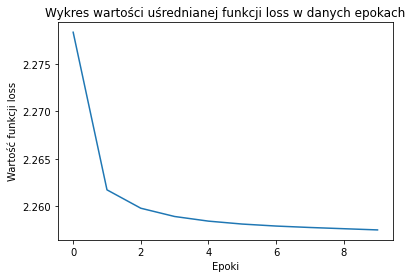

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


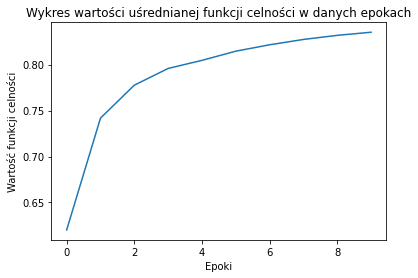

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.8173999786376953
	Iteration numer 1	accuracy: 0.8356000185012817
	Iteration numer 2	accuracy: 0.8396000266075134
	Iteration numer 3	accuracy: 0.8410999774932861
	Iteration numer 4	accuracy: 0.8429999947547913
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 10.064656066894532
	Wektorach wag nr: 1	Różnica: 0.3620354801416397
	Wektorach wag nr: 2	Różnica: 0.9963604569435119
	Wektorach wag nr: 3	Różnica: 0.45234981179237366
	Wektorach wag nr: 4	Różnica: 0.0
	Wektorach wag nr: 5	Różnica: 0.0
	Wektorach wag nr: 6	Różnica: 8.398030853271484
	Wektorach wag nr: 7	Różnica: 0.5433846175670624
	Wektorach wag nr: 8	Różnica:

In [ ]:
present_test_results(toa)

---
### **Opytmalizatora AdamW**

In [ ]:
#present_test_results(toaw)

---
### **Opytmalizatora SGD**

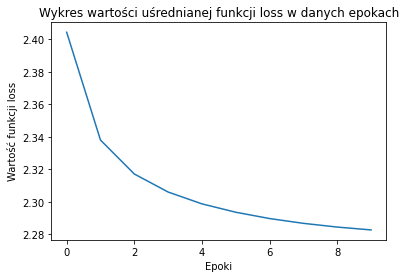

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


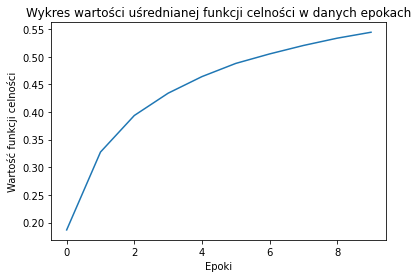

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.5428000092506409
	Iteration numer 1	accuracy: 0.5841000080108643
	Iteration numer 2	accuracy: 0.5174999833106995
	Iteration numer 3	accuracy: 0.5497999787330627
	Iteration numer 4	accuracy: 0.5273000001907349
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 9.786781692504883
	Wektorach wag nr: 1	Różnica: 0.09817701429128647
	Wektorach wag nr: 2	Różnica: 0.2962295889854431
	Wektorach wag nr: 3	Różnica: 0.16860591769218444
	Wektorach wag nr: 4	Różnica: 0.0
	Wektorach wag nr: 5	Różnica: 0.0
	Wektorach wag nr: 6	Różnica: 9.032339668273925
	Wektorach wag nr: 7	Różnica: 0.2226545125246048
	Wektorach wag nr: 8	Różnica:

In [ ]:
present_test_results(tosgd)

### Komentarz do wyników badań optymalizatorów
W badaniach pominięto optymalizator AdamW ze względu na błąd występujący w przy próbie używania go. 
Optymalizator SGD, mimo mniejszej różnicy w wartościach wag osiągnął gorsze accuracy niż optymalizator Adam. Przy użyciu obu optymalizatorów funkcja loss jest monotoniczna i malejąca. 

---
### **Wpływ parametru momentum używając batch normalization**

Wartość parametru momentum = 0.99


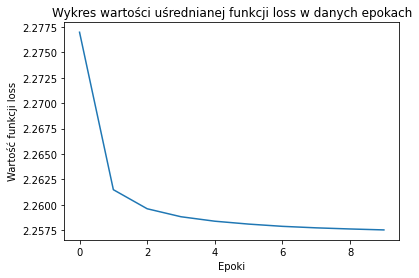

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


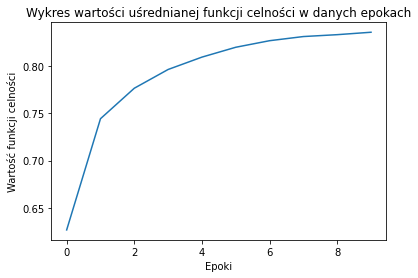

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.27005679309368
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.95


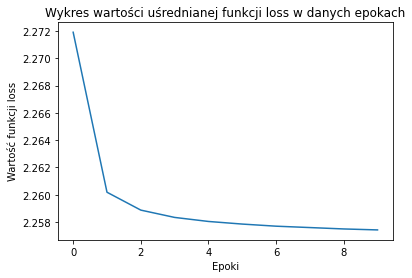

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


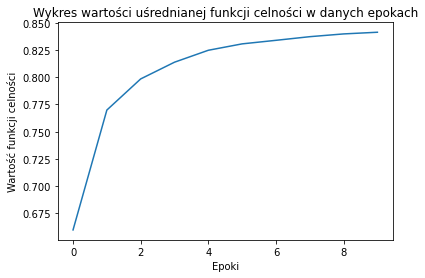

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.6043564081192
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.75


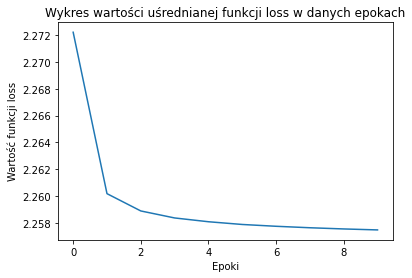

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


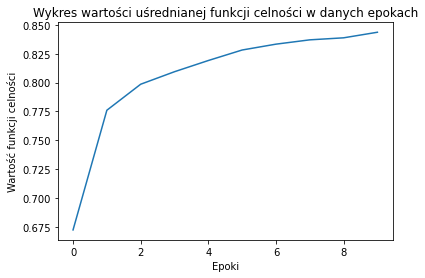

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.88137279748916
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.5


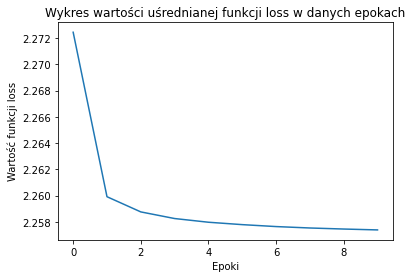

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


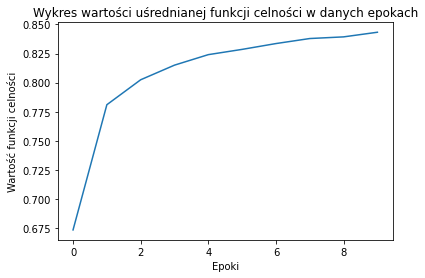

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.69018509089947
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.25


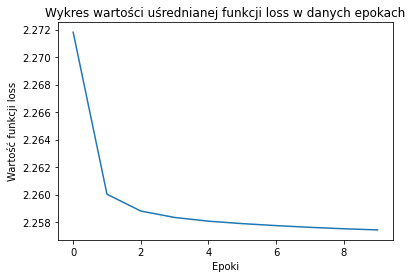

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


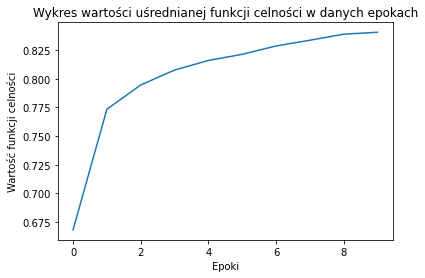

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.20786479115486
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0


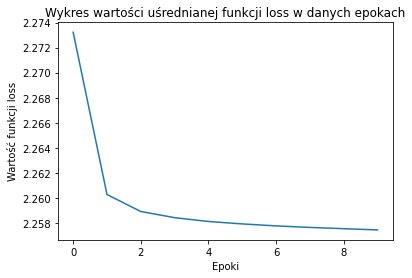

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


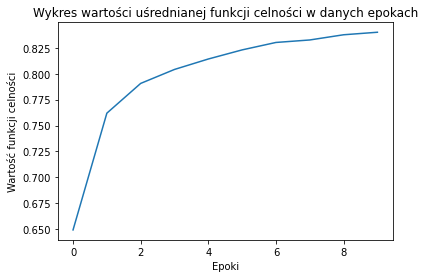

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.74209827780724
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, m in enumerate(momentum_values):
  print("Wartość parametru momentum = "+str(m))
  present_test_results_short(toa_m[i])

### Komentarz do wyników
Widoczny efekt jest taki, że proces nauki przebiega "łagodniej", gdy wartość momentum jest wyższa. Przez łagodniej rozumiemy w tym przypadku, że skoki accuracy pomiędzy kolejnymi epokami są mniejsze, ale ostateczny wynik się praktycznie nie różni. Wynik taki mógł zostać uzyskany, gdyż w modelu jest tylko jedna warstwa typu batch_normalization.

---
### **Wpływ parametru batch_size używając batch normalization**


Wartość parametru batch_size = 8


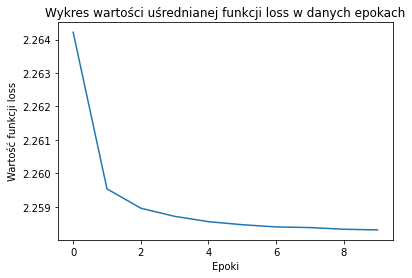

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


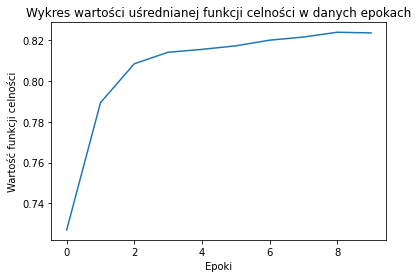

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 28.918450805544854
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 16


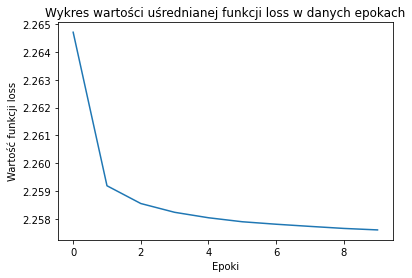

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


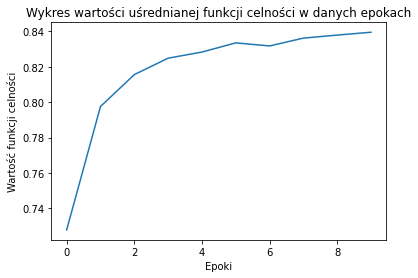

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 27.54251295924187
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 32


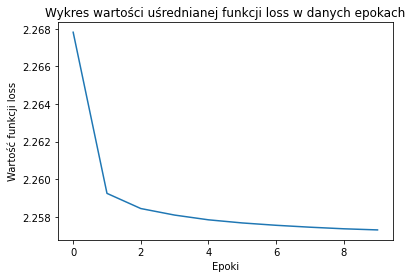

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


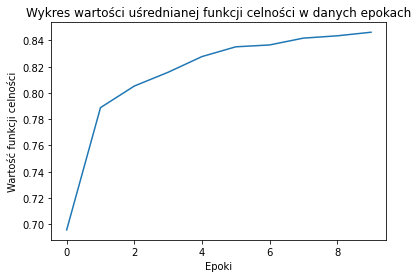

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.71992328763008
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 64


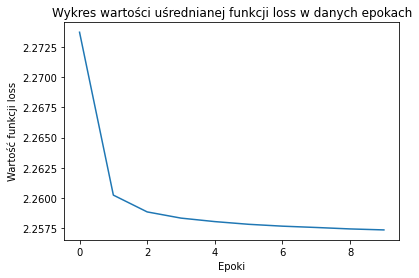

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


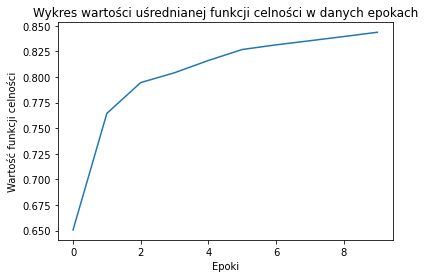

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.38360031247139
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 128


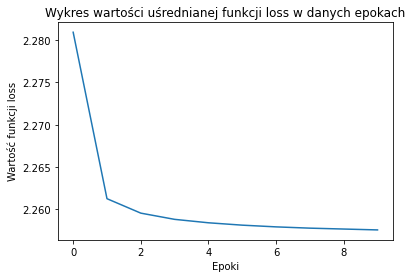

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


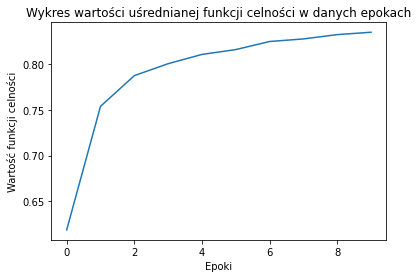

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.546881493926048
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 256


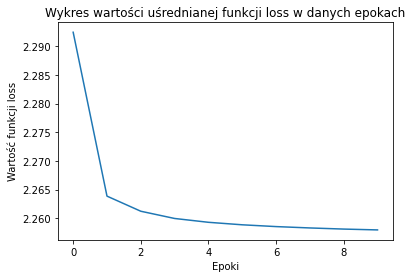

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


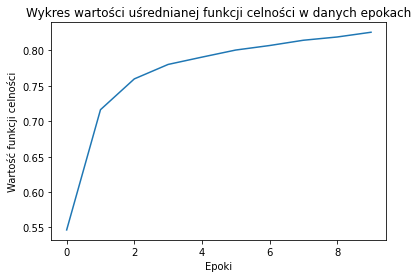

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.298742908239365
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, bs in enumerate(batch_size_values):
  print("Wartość parametru batch_size = "+str(bs))
  present_test_results_short(toa_bs[i])

### Komentarz do wyników
W wynikach naszego eksperymentu można zauważyć, że im większa jest wartość batch_size, tym łagodniej przebiega proces uczenia, a co za tym idzie funkcja wolniej się stabilizuje.

---
### **Wpływ parametru dropout_rate**

Wartość parametru dropout_rate = 0


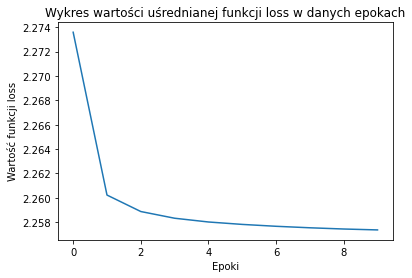

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


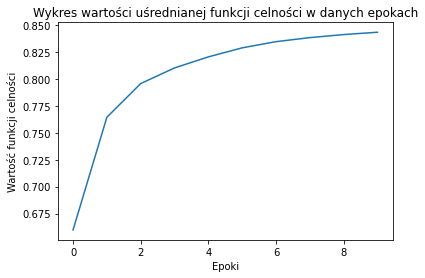

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.523814073204996
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout_rate = 0.2


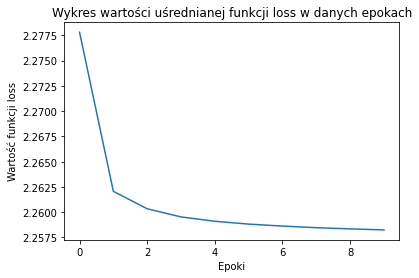

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


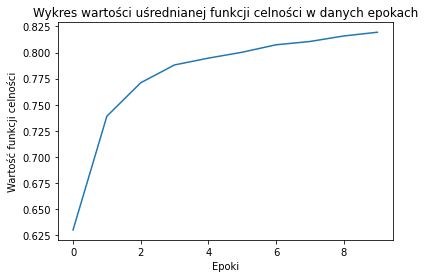

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 26.959404903650285
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout_rate = 0.4


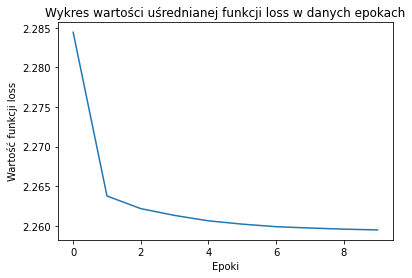

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


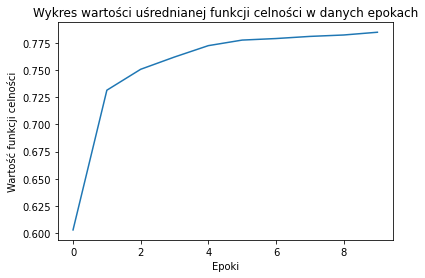

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 27.376048374176026
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout_rate = 0.6


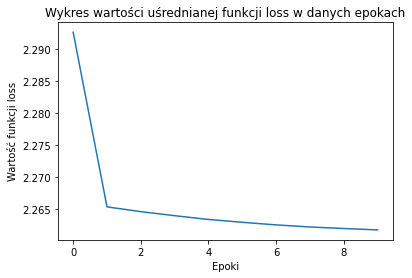

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


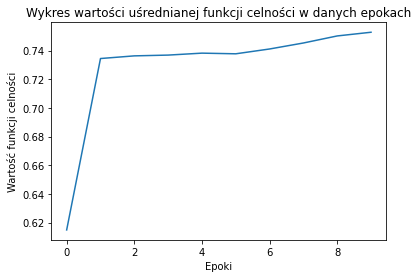

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 27.638498574495316
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout_rate = 0.8


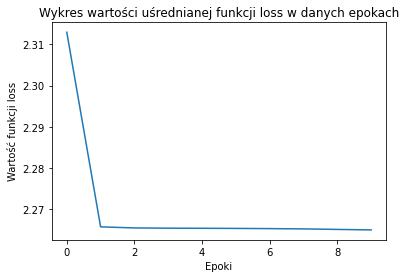

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


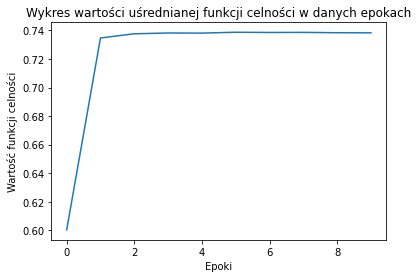

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 27.9628608494997
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, dr in enumerate(dropout_rate_values):
  print("Wartość parametru dropout_rate = "+str(dr))
  present_test_results_short(toa_dor[i])

### Komentarz do wyników
Łatwo można zauważyć, że dużej wartości dropout_rate funkcja szybko osiągna lokalne minimum i stabilizuje się. W naszych testach okazało się, że większa wartość dropout_rate wpływa nie tylko na przebieg funkcji, ale też na maksymalne wartości accuracy, jakie ta funkcja osiąga.

---
### **Wpływ parametru weight_decay używając optymalizatora AdamW**

In [ ]:
for i, wd in enumerate(wd_values):
  print("Wartość parametru weight_decay = "+str(wd))
  #present_test_results_short(toa_wd[i])

Wartość parametru weight_decay = 0
Wartość parametru weight_decay = 0.0001
Wartość parametru weight_decay = 0.0005
Wartość parametru weight_decay = 0.01
Wartość parametru weight_decay = 0.1
Wartość parametru weight_decay = 0.25
Wartość parametru weight_decay = 0.5


### Komentarz do wyników
W badaniach pominięto optymalizator AdamW ze względu na błąd występujący w przy próbie używania go. 

---
### **Wpływ używania regularyzatora typu kernel na wynik**

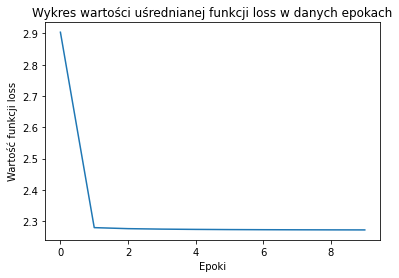

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


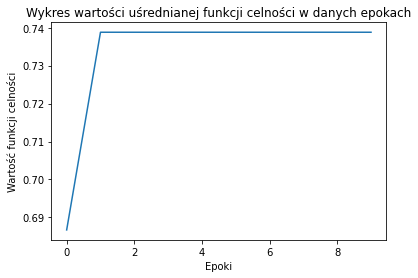

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.7387999892234802
	Iteration numer 1	accuracy: 0.7387999892234802
	Iteration numer 2	accuracy: 0.7387999892234802
	Iteration numer 3	accuracy: 0.7387999892234802
	Iteration numer 4	accuracy: 0.7387999892234802
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 6.942559146881104
	Wektorach wag nr: 1	Różnica: 0.3084141552448273
	Wektorach wag nr: 2	Różnica: 0.5334320425987243
	Wektorach wag nr: 3	Różnica: 0.45722392201423645
	Wektorach wag nr: 4	Różnica: 0.0
	Wektorach wag nr: 5	Różnica: 0.0
	Wektorach wag nr: 6	Różnica: 6.402875995635986
	Wektorach wag nr: 7	Różnica: 0.687066662311554
	Wektorach wag nr: 8	Różnica: 5

In [ ]:
present_test_results(torkl1)

### Komentarz do wyników
Regularyzator typu kernel wpływa negatywnie na proces uczenia, gdyż pomaga w bardzo szybkim wpadnięciu w minimum lokalne. Zachowanie takie może być spowodowane wartością 0 współczynnika dropout rate w przypadku testowanym. 

---
### **Wpływ używania regularyzatora typu bias na wynik**

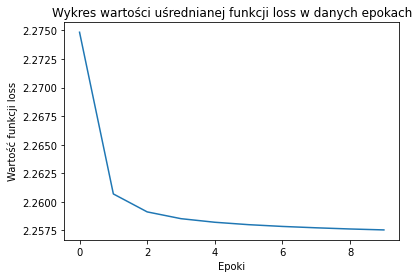

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


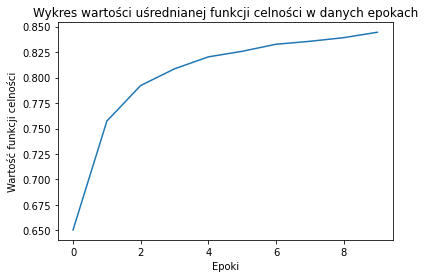

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.8446000218391418
	Iteration numer 1	accuracy: 0.8424999713897705
	Iteration numer 2	accuracy: 0.8396999835968018
	Iteration numer 3	accuracy: 0.8483999967575073
	Iteration numer 4	accuracy: 0.8472999930381775
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 10.077242851257324
	Wektorach wag nr: 1	Różnica: 0.0008871750207617879
	Wektorach wag nr: 2	Różnica: 1.043631410598755
	Wektorach wag nr: 3	Różnica: 0.5466474235057831
	Wektorach wag nr: 4	Różnica: 0.0
	Wektorach wag nr: 5	Różnica: 0.0
	Wektorach wag nr: 6	Różnica: 8.469454574584962
	Wektorach wag nr: 7	Różnica: 0.0013563299551606178
	Wektorach wag nr: 8	Różn

In [ ]:
present_test_results(torbl1)

### Komentarz do wyników
Regulator typu bias pozwala osiągnąć mniejszą różnicę wektora wag, niż przypadek bazowy (Test optymalizator Adam) przy zachowaniu lepszej wartości accuracy.

---
### **Wpływ używania regularyzatora typu activity na wynik**

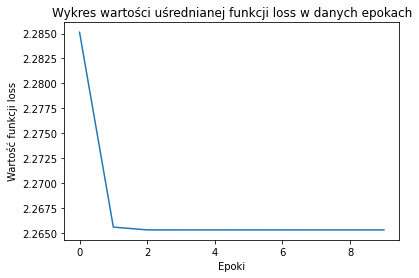

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


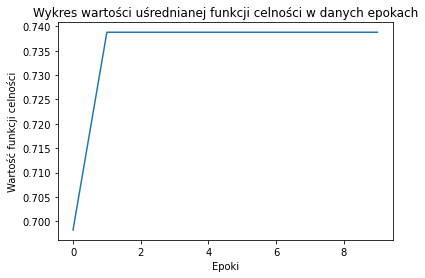

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.7387999892234802
	Iteration numer 1	accuracy: 0.7387999892234802
	Iteration numer 2	accuracy: 0.7387999892234802
	Iteration numer 3	accuracy: 0.7387999892234802
	Iteration numer 4	accuracy: 0.7387999892234802
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 10.336483573913574
	Wektorach wag nr: 1	Różnica: 0.40106924772262575
	Wektorach wag nr: 2	Różnica: 0.4112075686454773
	Wektorach wag nr: 3	Różnica: 0.40028841495513917
	Wektorach wag nr: 4	Różnica: 0.0
	Wektorach wag nr: 5	Różnica: 0.0
	Wektorach wag nr: 6	Różnica: 8.604593276977539
	Wektorach wag nr: 7	Różnica: 0.6523686051368713
	Wektorach wag nr: 8	Różnica

In [ ]:
present_test_results(toral1)

### Komentarz do wyników
Regularyzator typu activity wpływa negatywnie na proces uczenia, gdyż pomaga w bardzo szybkim wpadnięciu w minimum lokalne. Zachowanie takie może być spowodowane wartością 0 współczynnika dropout rate w przypadku testowanym. 


---

---
## **Wyniki dla modeli konwolucyjnych sieci neuronowych**

---
### **Optymalizator Adam**

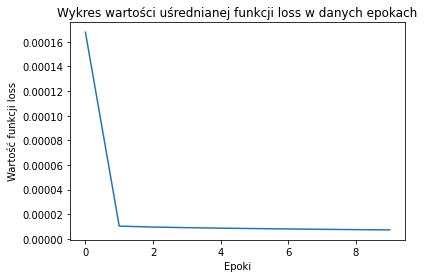

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


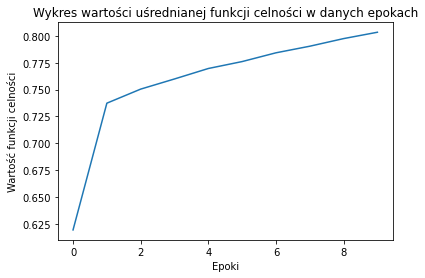

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.7321000099182129
	Iteration numer 1	accuracy: 0.8248000144958496
	Iteration numer 2	accuracy: 0.8429999947547913
	Iteration numer 3	accuracy: 0.8281000256538391
	Iteration numer 4	accuracy: 0.7888000011444092
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 1.9341057538986206
	Wektorach wag nr: 1	Różnica: 0.16117572635412217
	Wektorach wag nr: 2	Różnica: 6.474662208557129
	Wektorach wag nr: 3	Różnica: 0.1959546484053135
	Wektorach wag nr: 4	Różnica: 12.228444862365723
	Wektorach wag nr: 5	Różnica: 0.1494337387382984
	Wektorach wag nr: 6	Różnica: 0.31705316007137296
	Wektorach wag nr: 7	Różnica: 0.232500213384628

In [ ]:
present_test_results(tkoa)

---
### **Optymalizator AdamW**

In [ ]:
#present_test_results(tkoaw)

---
### **Optymalizator SGD**

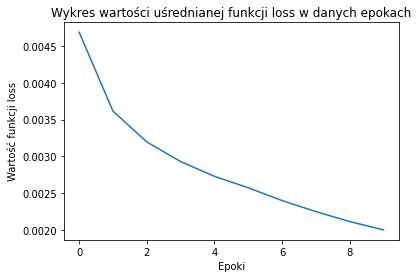

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


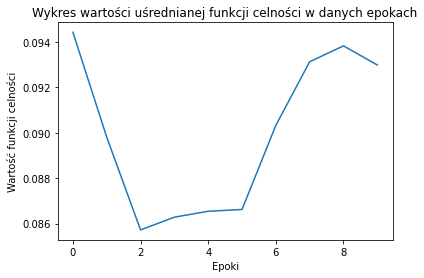

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.07320000231266022
	Iteration numer 1	accuracy: 0.13519999384880066
	Iteration numer 2	accuracy: 0.131400004029274
	Iteration numer 3	accuracy: 0.09629999846220016
	Iteration numer 4	accuracy: 0.08420000225305557
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 1.9234628677368164
	Wektorach wag nr: 1	Różnica: 0.029175142385065557
	Wektorach wag nr: 2	Różnica: 6.51817216873169
	Wektorach wag nr: 3	Różnica: 0.042009657621383666
	Wektorach wag nr: 4	Różnica: 11.164504051208496
	Wektorach wag nr: 5	Różnica: 0.030758432298898696
	Wektorach wag nr: 6	Różnica: 0.025456321239471436
	Wektorach wag nr: 7	Różnica: 0.0198451

In [ ]:
present_test_results(tkosgd)

### Komentarz do wyników badań optymalizatorów
W badaniach pominięto optymalizator AdamW ze względu na błąd występujący w przy próbie używania go. 

Przeprowadzone przez nas testy wykazały, że optymalizator SGD radzi sobie znacznie gorzej niż Adam w przypadku naszego modelu.

---
### **Wpływ parametru momentum używając batch normalization**

Wartość parametru momentum = 0.99


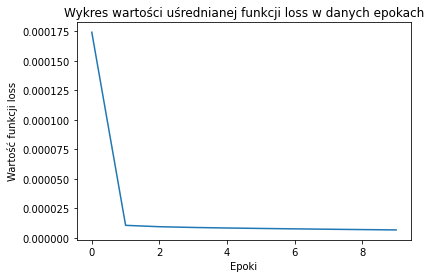

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


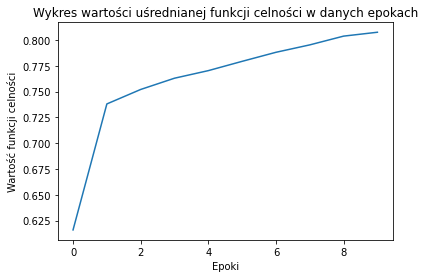

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 35.61835485100746
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.95


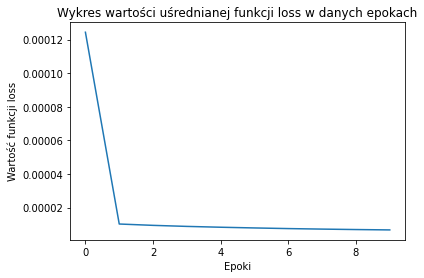

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


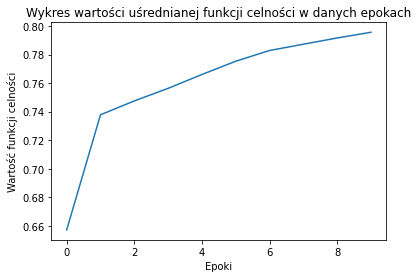

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 33.357678566873076
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.75


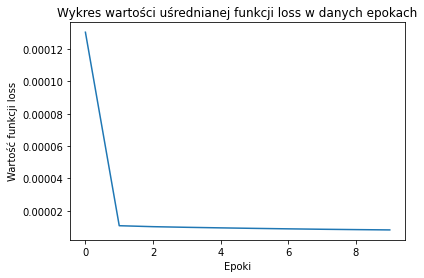

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


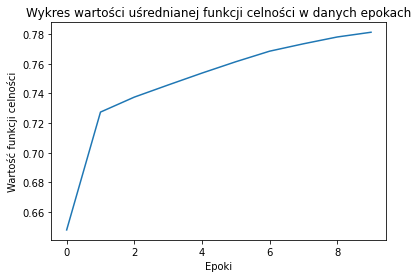

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 33.62743911743164
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.5


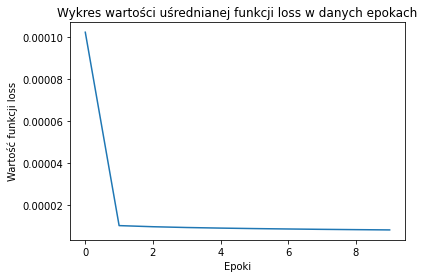

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


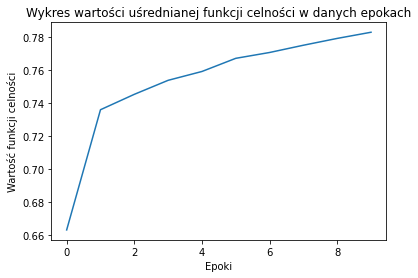

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 33.84844612628221
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0.25


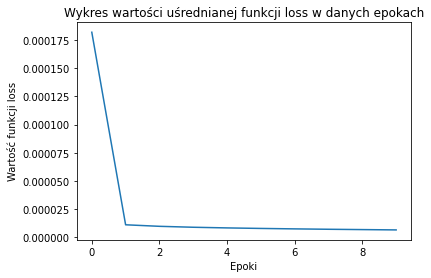

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


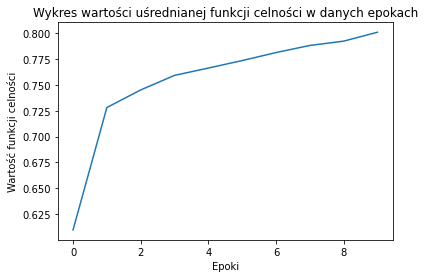

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.107729089260104
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru momentum = 0


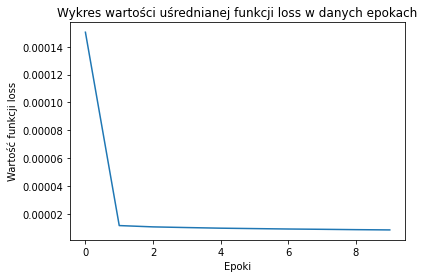

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


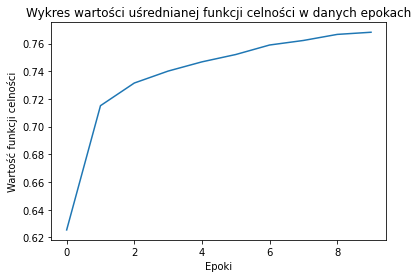

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 37.125448507070544
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, m in enumerate(momentum_kvalues):
  print("Wartość parametru momentum = "+str(m))
  present_test_results_short(tkoa_m[i])

### Komentarz do wyników

---
### **Wpływ parametru batch_size używając batch normalization**

Wartość parametru batch_size = 8


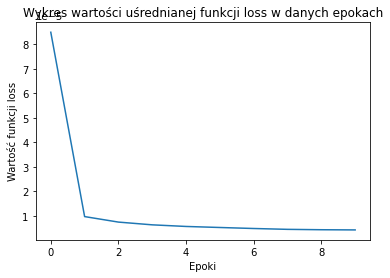

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


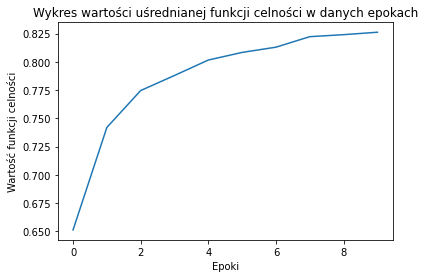

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 34.45819191634655
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 16


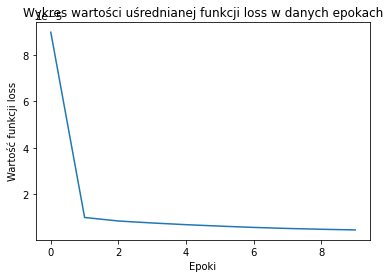

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


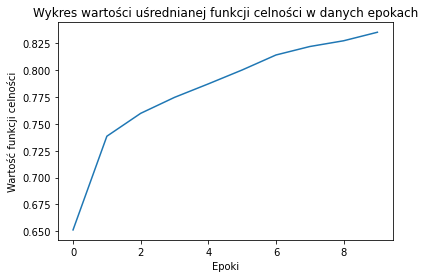

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.63623610436916
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 32


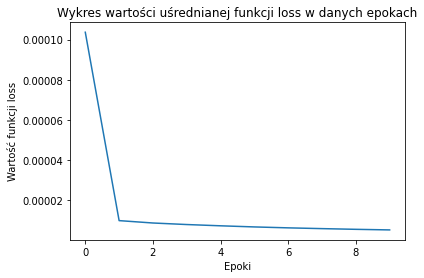

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


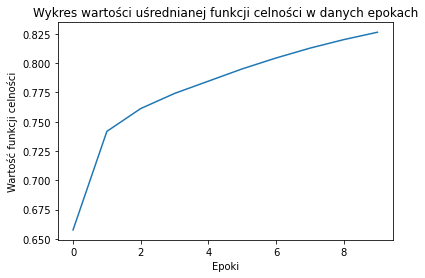

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 35.09289766252041
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 64


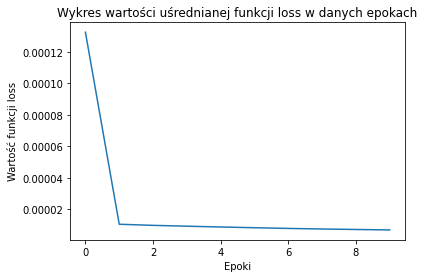

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


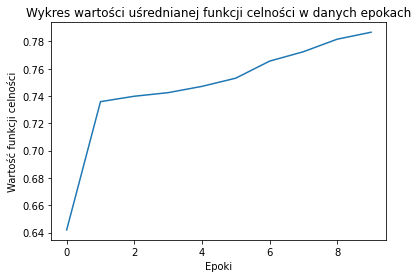

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 34.36751612722874
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 128


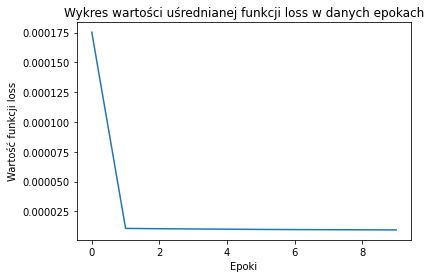

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


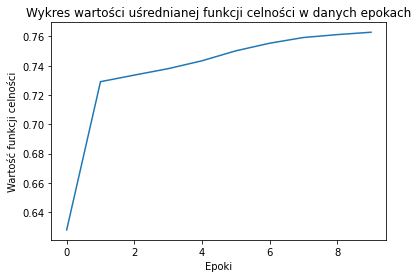

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 32.94360361577164
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru batch_size = 256


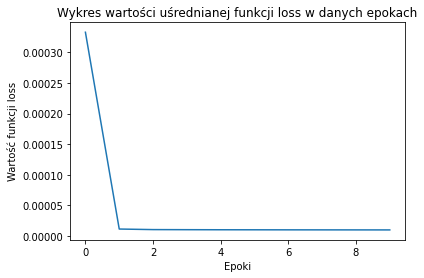

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


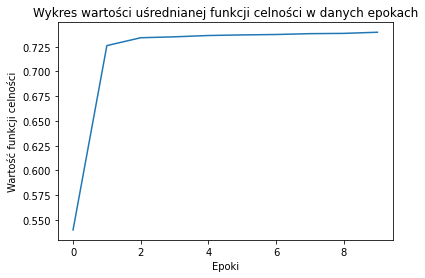

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 33.32803609327239
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, bs in enumerate(batch_size_values):
  print("Wartość parametru batch_size = "+str(bs))
  present_test_results_short(tkoa_bs[i])

### Komentarz do wyników
Podczas badań udało nam się wykazać, że zwiększenie batch_size przynosi negatywny efekt jeśli chodzi o wartości accuracy przy uczeniu modelu.

---
### **Wpływ parametru dropout_rate**

Wartość parametru dropout rate = 8


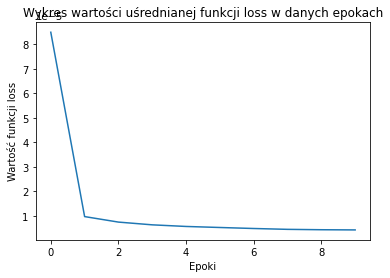

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


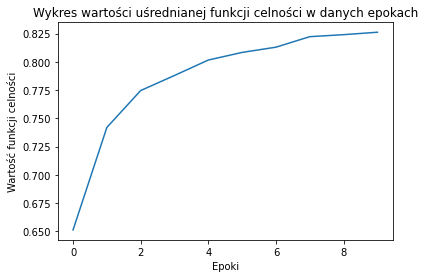

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 34.45819191634655
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout rate = 16


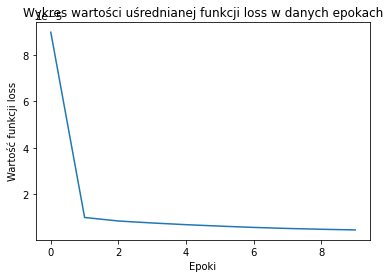

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


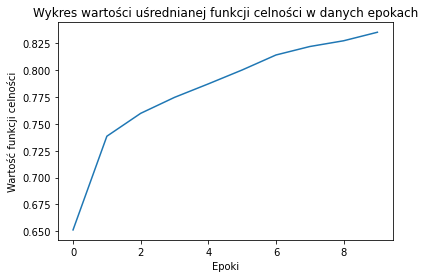

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 36.63623610436916
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout rate = 32


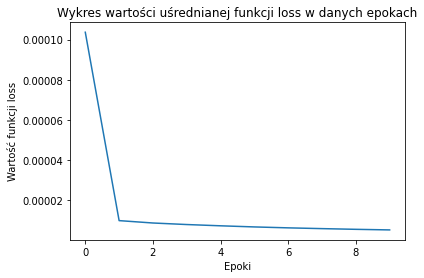

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


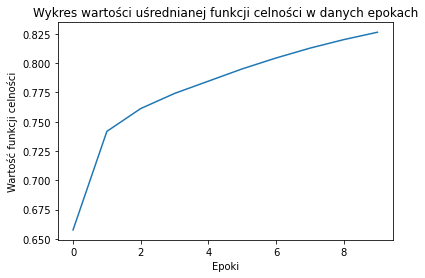

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 35.09289766252041
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout rate = 64


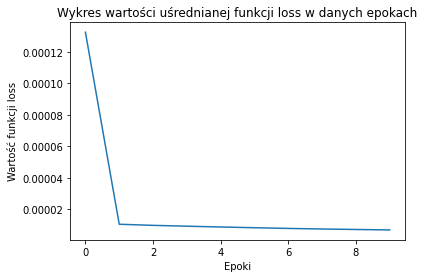

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


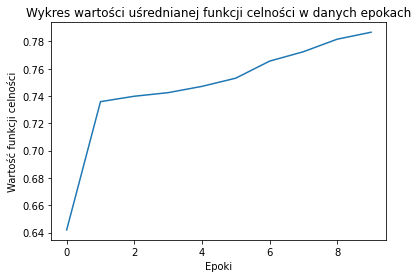

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 34.36751612722874
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout rate = 128


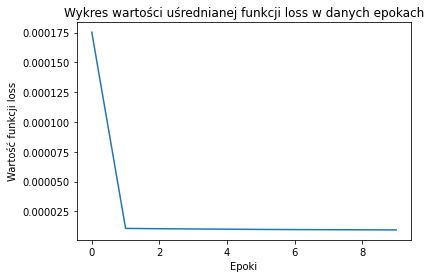

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


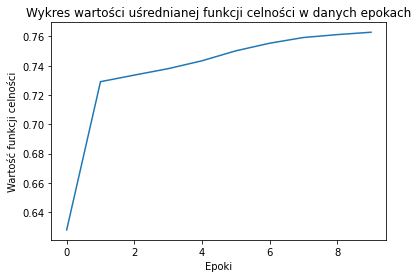

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 32.94360361577164
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Wartość parametru dropout rate = 256


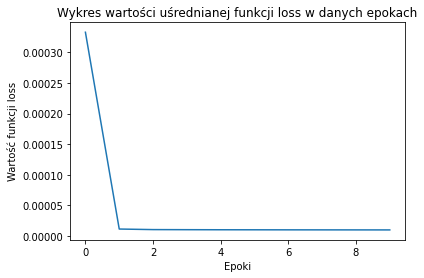

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


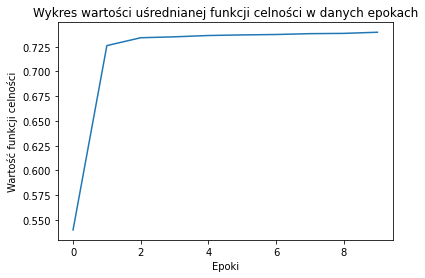

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Suma ze średnich różnic wartości wag w poszczególnych wektorach wag: 33.32803609327239
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
for i, dr in enumerate(batch_size_kvalues):
  print("Wartość parametru dropout rate = "+str(dr))
  present_test_results_short(tkoa_bs[i])

### Komentarz do wyników

Tak jak w przypadku tego badania dla poprzedniego rodzaju sieci okazało się, że nadmierne zwiększanie wartości dropout_rate przynosi bardzo negatywne skutki w procesie uczenia modelu.

---
### **Wpływ parametru weight_decay używając optymalizatora AdamW**

In [ ]:
for i, wd in enumerate(wd_kvalues):
  print("Wartość parametru weight decay = "+str(wd))
  #present_test_results_short(tkoaw_wd[i])

Wartość parametru weight decay = 0
Wartość parametru weight decay = 0.0001
Wartość parametru weight decay = 0.0005
Wartość parametru weight decay = 0.01
Wartość parametru weight decay = 0.1
Wartość parametru weight decay = 0.25
Wartość parametru weight decay = 0.5


### Komentarz do wyników
W badaniach pominięto optymalizator AdamW ze względu na błąd występujący w przy próbie używania go. 

---
### **Wpływ używania regularyzatora typu kernel na wynik**

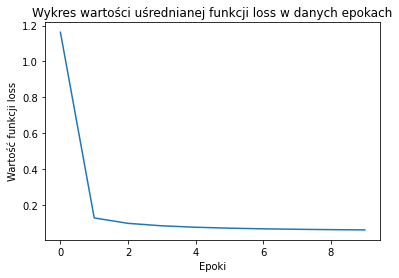

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


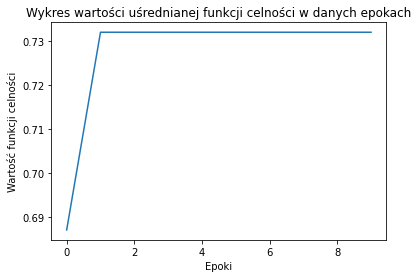

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.7321000099182129
	Iteration numer 1	accuracy: 0.7321000099182129
	Iteration numer 2	accuracy: 0.7321000099182129
	Iteration numer 3	accuracy: 0.7321000099182129
	Iteration numer 4	accuracy: 0.7321000099182129
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 1.3965230941772462
	Wektorach wag nr: 1	Różnica: 0.18837498128414154
	Wektorach wag nr: 2	Różnica: 4.608296298980713
	Wektorach wag nr: 3	Różnica: 0.25386387705802915
	Wektorach wag nr: 4	Różnica: 7.9146734237670895
	Wektorach wag nr: 5	Różnica: 0.3091902732849121
	Wektorach wag nr: 6	Różnica: 0.35512704849243165
	Wektorach wag nr: 7	Różnica: 0.25894003808498

In [ ]:
present_test_results(tkorkl1)

### Komentarz do wyników
Regularyzator typu kernel wpływa negatywnie na proces uczenia, gdyż pomaga w bardzo szybkim wpadnięciu w minimum lokalne. Zachowanie takie może być spowodowane wartością 0 współczynnika dropout rate w przypadku testowanym. 

---


### **Wpływ używania regularyzatora typu bias na wynik**

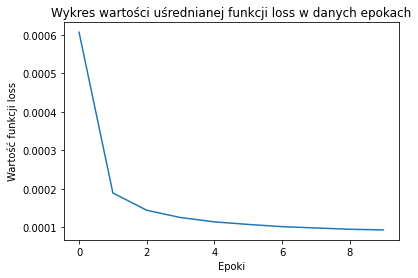

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


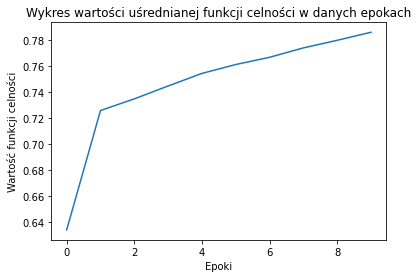

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.820900022983551
	Iteration numer 1	accuracy: 0.7967000007629395
	Iteration numer 2	accuracy: 0.7782999873161316
	Iteration numer 3	accuracy: 0.8032000064849854
	Iteration numer 4	accuracy: 0.7321000099182129
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 1.797597885131836
	Wektorach wag nr: 1	Różnica: 0.00048406817950308323
	Wektorach wag nr: 2	Różnica: 6.496889400482178
	Wektorach wag nr: 3	Różnica: 0.0007567686610855162
	Wektorach wag nr: 4	Różnica: 12.361149024963378
	Wektorach wag nr: 5	Różnica: 0.000832916796207428
	Wektorach wag nr: 6	Różnica: 0.4095573365688324
	Wektorach wag nr: 7	Różnica: 0.2483469396

In [ ]:
present_test_results(tkorbl1)

### Komentarz do wyników
Regulator typu bias nie wpłyną pozytywnie na proces nauki, gdyż w porównaniu w przypadku, gdy go nie ma (Test optymalizator Adam), osiąga gorszą ostateczną wartość accuracy pomimo mniejszej różnicy wektora wag.

---

### **Wpływ używania regularyzatora typu activity na wynik**

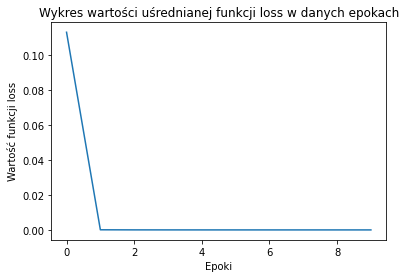

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*


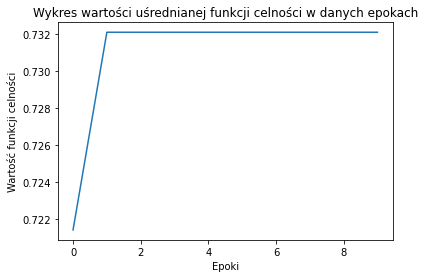

*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Największa otrzymana wartość accuracy przez poszczególne iteracje:
	Iteration numer 0	accuracy: 0.7321000099182129
	Iteration numer 1	accuracy: 0.7321000099182129
	Iteration numer 2	accuracy: 0.7321000099182129
	Iteration numer 3	accuracy: 0.7321000099182129
	Iteration numer 4	accuracy: 0.7321000099182129
*--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--**--*
Średnia różnica wartości wag w poszczególnyh wektorach wag:
	Wektorach wag nr: 0	Różnica: 1.9727535486221313
	Wektorach wag nr: 1	Różnica: 0.46899924874305726
	Wektorach wag nr: 2	Różnica: 6.7749924659729
	Wektorach wag nr: 3	Różnica: 0.3926300942897797
	Wektorach wag nr: 4	Różnica: 12.505068588256837
	Wektorach wag nr: 5	Różnica: 0.18432664573192598
	Wektorach wag nr: 6	Różnica: 0.15831541419029235
	Wektorach wag nr: 7	Różnica: 0.2390789538621902

In [ ]:
present_test_results(tkoral1)

### Komentarz do wyników
Regularyzator typu activity wpływa negatywnie na proces uczenia, gdyż pomaga w bardzo szybkim wpadnięciu w minimum lokalne. Zachowanie takie może być spowodowane wartością 0 współczynnika dropout rate w przypadku testowanym. 